# FiftyOne: Flower Dataset - Classification

In [35]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import ast

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob

from sklearn.manifold import TSNE

## 1. Load Dataset File

In [7]:
df = pd.read_csv('../datasets/vectors_dataset.csv')
df['embedding'] = df['embedding'].apply(ast.literal_eval)

In [20]:
df.columns

Index(['filename', 'filepath', 'label', 'linear_pred', 'embedding', 'cluster'], dtype='object')

In [4]:
df.head()

,filename,filepath,label,linear_pred,embedding,cluster
0,10140303196_b88d3d6cec.jpg,../datasets/flowers/train\daisy\10140303196_b8...,daisy,daisy,"[-0.5338386297225952, -0.7343480587005615, 0.3...",2
1,10172379554_b296050f82_n.jpg,../datasets/flowers/train\daisy\10172379554_b2...,daisy,daisy,"[0.058685123920440674, -1.1110296249389648, 0....",1
2,10172567486_2748826a8b.jpg,../datasets/flowers/train\daisy\10172567486_27...,daisy,daisy,"[-0.2931477725505829, -1.0281589031219482, 0.0...",2
3,10172636503_21bededa75_n.jpg,../datasets/flowers/train\daisy\10172636503_21...,daisy,daisy,"[-0.8797124624252319, -0.700323760509491, -0.0...",1
4,10391248763_1d16681106_n.jpg,../datasets/flowers/train\daisy\10391248763_1d...,daisy,daisy,"[0.512474000453949, -0.4610719680786133, 0.934...",1


In [18]:
def get_absolute_path(relative_path):
    """
    Given a relative file path,
    resolve its absolute path.
    """
    base_path = Path.cwd()  # gets the current working directory
    absolute_path = (base_path / relative_path).resolve()
    return absolute_path

def visualize_image(df, index, filepath_col="filepath"):
    """
    Visualizes an image given the index of the DataFrame row.
    
    Parameters:
    - df: pandas DataFrame containing the file paths of images under the column filepath_col
    - index: Index (int) of the DataFrame row containing the file path
    - filepath_col (str): column nam ein df which contains the file paths; default: "filepath"
    """
    if index < 0 or index >= len(df):
        raise ValueError("Index out of bounds")

    # Assuming the 'filepath' column contains relative paths like '../datasets/flowers/train/daisy/image.jpg'
    relative_image_path = df.iloc[index][filepath_col]
    
    # Convert to absolute path
    absolute_image_path = get_absolute_path(relative_image_path)

    # Load and display the image
    img = mpimg.imread(absolute_image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    plt.show()

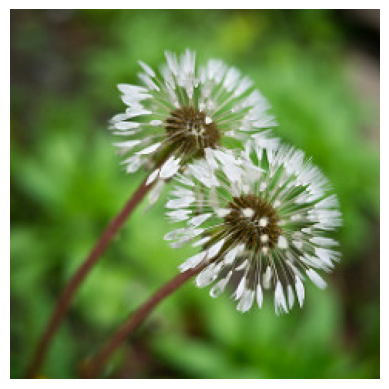

In [19]:
visualize_image(df,1000)

In [22]:
# Convert 'filepath' to absolute paths
df['filepath'] = df['filepath'].apply(get_absolute_path)

## 2. Create FiftyOne Dataset and Visualize It

In [25]:
# Initialize FiftyOne dataset
dataset = fo.Dataset("flowers_dataset")

In [28]:
# Loop over DataFrame's rows and create FiftyOne samples
for index, row in df.iterrows():
    # Create FiftyOne sample
    sample = fo.Sample(
        filepath=row['filepath'],
        ground_truth=fo.Classification(label=row['label']),
        linear_pred=fo.Classification(label=row['linear_pred']),
        # Add embedding as a FiftyOne vector field; must convert to a list
        embedding=np.array(row['embedding']).tolist(),
        # Convert cluster id to string before creating Classification
        cluster=fo.Classification(label=str(row['cluster']))
    )

    # Add sample to dataset
    dataset.add_sample(sample)

In [30]:
# Launch the FiftyOne app
# Right click on cell -> Create New View for Cell Output
session = fo.launch_app(dataset)

In [33]:
# Optional: Create 2D embeddings for visualization with UMAP or t-SNE
# Extract embeddings into a numpy array
embeddings = np.stack(df['embedding'].values)

# Compute 2D embeddings
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

In [34]:
# Add 2D embeddings to the samples
for sample, embedding_2d in zip(dataset, reduced_embeddings):
    sample['embedding_tsne_2d'] = embedding_2d.tolist()
    sample.save()

# Save the dataset after all samples are added
dataset.save()

In [ ]:
# Compute visual uniqueness
# https://docs.voxel51.com/user_guide/brain.html#image-uniqueness
# A model is downloaded for us and a scalar [0, 1]
# related to the uniqueness of each image is computed
# following different computations: embeddings, neighbors, etc.
# Unique samples are vital in creating training batches
# that help your model learn as efficiently and effectively as possible.
fob.compute_uniqueness(dataset)

In [39]:
# Delete the field from the dataset
try:
    dataset.delete_sample_field("embedding_2d")
except AttributeError as err:
    pass

In [41]:
# Compute 2D representation
# We can select one of the default methods
# point to a model or a field in our dataset where vectors are stored
# https://docs.voxel51.com/api/fiftyone.brain.html#fiftyone.brain.compute_visualization
results = fob.compute_visualization(
    dataset,
    points=reduced_embeddings,
    brain_key="flowers_tsne_2d",
    verbose=True,
    seed=51,
)
# Now, we can reload the UI frame
# check the "Embeddings" tab in the main frame
# There, we select the brain_key "flowers_tsne_2d"

Ignoring unsupported parameters {'verbose', 'seed'} for <class 'fiftyone.brain.visualization.ManualVisualizationConfig'>


In [42]:
plot = results.visualize(labels="ground_truth.label")
plot.show(height=720)

FigureWidget({
    'data': [{'customdata': array(['65478a0c920df89f852a1aff', '65478a0c920df89f852a1b03',
                                   '65478a0c920df89f852a1b07', ..., '65478a0e920df89f852a22c7',
                                   '65478a0e920df89f852a22cb', '65478a0e920df89f852a22cf'], dtype=object),
              'hovertemplate': ('<b>label: %{text}</b><br>x, y ' ... ': %{customdata}<extra></extra>'),
              'line': {'color': '#3366CC'},
              'mode': 'markers',
              'name': 'daisy',
              'showlegend': True,
              'text': array(['daisy', 'daisy', 'daisy', ..., 'daisy', 'daisy', 'daisy'], dtype='<U5'),
              'type': 'scattergl',
              'uid': 'dd08ab79-990b-49f3-8431-05f3063e76b1',
              'x': array([25.155155, 44.89105 ,  8.613078, ..., 30.078953, 30.749   , 10.42914 ],
                         dtype=float32),
              'y': array([-21.573757,   9.9862  , -42.470093, ..., -37.049175, -34.972706,
                

In [43]:
# Attach plot to session:
# necessary to interact with Plotly -> Web UI
session.plots.attach(plot)

## 3. Train Model and Evaluate Predictions

In [48]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [61]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 25),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }

    clf = XGBClassifier(**param)

    return cross_val_score(clf, X_train, y_train, n_jobs=-1, scoring='f1_macro', cv=3).mean()

In [62]:
X = np.stack(df['embedding'].values)
y_org = df['label'].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_org)

In [63]:
# Perform the split and get the indices
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X,
    y,
    range(X.shape[0]),
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [64]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2023-11-05 16:33:46,418] A new study created in memory with name: no-name-4fe63fa5-2d5d-4436-aaff-2dac60c01f98
[I 2023-11-05 16:33:58,621] Trial 0 finished with value: 0.07622549259277367 and parameters: {'n_estimators': 752, 'max_depth': 6, 'learning_rate': 0.23272278513526526, 'subsample': 0.8875842592346596, 'colsample_bytree': 0.9559021854163772, 'min_child_weight': 253}. Best is trial 0 with value: 0.07622549259277367.
[I 2023-11-05 16:34:05,609] Trial 1 finished with value: 0.7540472127064805 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.22529566877237364, 'subsample': 0.9979966875353639, 'colsample_bytree': 0.9674773295527623, 'min_child_weight': 176}. Best is trial 1 with value: 0.7540472127064805.
[I 2023-11-05 16:34:16,343] Trial 2 finished with value: 0.6173963101473093 and parameters: {'n_estimators': 809, 'max_depth': 17, 'learning_rate': 0.20029457468389117, 'subsample': 0.7595011161597769, 'colsample_bytree': 0.9606751533712863, 'min_child_w

In [65]:
best_params = study.best_params
print("Best params:", best_params)

Best params: {'n_estimators': 351, 'max_depth': 23, 'learning_rate': 0.176799140479369, 'subsample': 0.5044144133534397, 'colsample_bytree': 0.5905650431516173, 'min_child_weight': 6}


In [66]:
xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5905650431516173, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.176799140479369,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=23, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=351, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [67]:
# Get the predicted probabilities for each class
train_probabilities = xgb_clf.predict_proba(X_train)
test_probabilities = xgb_clf.predict_proba(X_test)

In [68]:
# Create dictionaries to map from index to prediction,
# including the probabilities
train_predictions = {
    idx: {
        'label': label_encoder.inverse_transform([label])[0],
        'confidence': confidence,
        'probabilities': probabilities.tolist()
    }
    for idx, label, confidence, probabilities in zip(
        indices_train,
        np.argmax(train_probabilities, axis=1),
        np.max(train_probabilities, axis=1),
        train_probabilities
    )
}

test_predictions = {
    idx: {
        'label': label_encoder.inverse_transform([label])[0],
        'confidence': confidence,
        'probabilities': probabilities.tolist()
    }
    for idx, label, confidence, probabilities in zip(
        indices_test,
        np.argmax(test_probabilities, axis=1),
        np.max(test_probabilities, axis=1),
        test_probabilities
    )
}

In [82]:
def add_predictions(df,
                    dataset,
                    train_predictions,
                    test_predictions):
    # Add predictions, probabilities, and tags to FiftyOne
    for index, row in df.iterrows():
        sample = dataset[str(row['filepath'])]
        
        if index in train_predictions:
            pred = train_predictions[index]
            sample.tags.append('train')
        else:
            pred = test_predictions[index]
            sample.tags.append('test')
        
        # Store the probabilities alongside the label and confidence
        sample['prediction'] = fo.Classification(
            label=pred['label'],
            confidence=float(pred['confidence']),
            probabilities=pred['probabilities']
        )
        sample.save()

add_predictions(df,
                dataset,
                train_predictions,
                test_predictions)

In [83]:
def add_evaluation_tags(dataset):
    for sample in dataset:
        # Retrieve the ground truth and predicted labels
        ground_truth_label = sample['ground_truth'].label
        predicted_label = sample['prediction'].label
        
        # Determine the type of outcome and add the appropriate tag
        if ground_truth_label == predicted_label:
            if predicted_label:  # if the label is not a negative/absence class
                sample.tags.append('TP')  # True Positive
            else:
                sample.tags.append('TN')  # True Negative
        else:
            if predicted_label:
                sample.tags.append('FP')  # False Positive
            else:
                sample.tags.append('FN')  # False Negative

        # Save the changes to the sample
        sample.save()

In [84]:
# Call the function to add evaluation tags
add_evaluation_tags(dataset)